In [5]:
#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import torch
from STOMPnet import STOMPnet

In [6]:
def get_untrained_STOMPnet(training_dict,data_settings):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using {device} device", flush=True)

    # Abstraction system
    num_abs_agents = training_dict['model_paras']['M']
    abs_action_space_dim =  training_dict['model_paras']['L']  # number of discrete abstract actions
    # abstract action policy network parameters
    hidden_capacity = training_dict['model_paras']['hidden_capacity']
    enc_hidden_dim = int(hidden_capacity/num_abs_agents)
    action_space_dim = 2
    state_space_dim = data_settings['sys_parameters']['K']
    num_agents = data_settings['sys_parameters']['N']
    # Initialize abstraction system model
    net = STOMPnet(
                state_space_dim,
                abs_action_space_dim,
                enc_hidden_dim,
                num_agents,
                num_abs_agents,
                action_space_dim=action_space_dim
            )
    net.to(device)
    state_dict=net.state_dict()
    print(f"has {sum(p.numel() for p in state_dict.values())} parameters")
    return net
    
from torch import nn
import itertools

def get_probs_on_vertices_from_model(net,data_settings):
    net.eval()
    with torch.no_grad():
        vertex_states = torch.Tensor(list(itertools.product([0, 1], repeat=data_settings['sys_parameters']['K'])))
        logit_arrays=net(vertex_states)
        f=nn.Softmax(dim=-1)
        return np.array(f(logit_arrays))

In [20]:
data_settings_str =\
                '_4agentdebug' +\
                '_modelname_bitpop' +\
                '_corr_1.0' +\
                '_ensemble_sum' +\
                '_M_2' +\
                '_simulationdata' +\
                '_actsel_greedy' +\
                '_numepi_1' +\
                '_K_5' +\
                '_N_4' +\
                '_T_512' +\
                '_sps_16'
#                 f'_g_8.0'
print(data_settings_str)
seed_idx = 0
#  '_singletaskbaseline' +\
#                 '_multitaskbaseline' +\
#  '_STOMPnet_M_2_L_4_nfeatures_2' +\
training_settings_str =\
 '_STOMPnet_M_2_L_100_nfeatures_2' +\
                '_cap_240' +\
                '_trainseed_0' +\
                '_epochs_200' +\
                '_batchsz_16' +\
                '_lr_5e-05'
print(training_settings_str)

_4agentdebug_modelname_bitpop_corr_1.0_ensemble_sum_M_2_simulationdata_actsel_greedy_numepi_1_K_5_N_4_T_512_sps_16
_STOMPnet_M_2_L_100_nfeatures_2_cap_240_trainseed_0_epochs_200_batchsz_16_lr_5e-05


In [21]:
out_dir = "output/"
data_settings = np.load(out_dir + data_settings_str + ".npy", allow_pickle=True).item()

data_root = out_dir +data_settings_str + f"_dataseed_{seed_idx}"
training_data = np.load(data_root+".npy", allow_pickle=True).item()
experiment_label = 'lossgoesdownexample'
training_root = out_dir + experiment_label + data_settings_str + f"_dataseed_{seed_idx}"+training_settings_str
training_dict = np.load(training_root + ".npy", allow_pickle=True).item()
trained_model_state_dict = torch.load(out_dir + data_settings_str + f"_dataseed_{seed_idx}"+training_settings_str + '_state_dict.pt')
import json
print('data_settings')
print(json.dumps(data_settings,sort_keys=True, indent=4))
print('\ntraining_data')
for key in trained_model_state_dict.keys():
    print(key+" "+str(trained_model_state_dict[key].requires_grad))
print(json.dumps(training_dict,sort_keys=True, indent=4))
print(f"\nmodel has {sum(p.numel() for p in trained_model_state_dict.values())} parameters grouped as:")

data_settings
{
    "actsel": "greedy",
    "dataset_label": "4agentdebug_modelname_bitpop_corr_1.0_ensemble_sum_M_2",
    "episode_length": 512,
    "num_episodes": 1,
    "num_seeds": 10,
    "sys_parameters": {
        "K": 5,
        "N": 4,
        "action_space_dim": 2,
        "jointagent_groundmodel_paras": {
            "M": 2,
            "corr": 1.0,
            "ensemble": "sum",
            "modelname": "bitpop"
        },
        "samples_per_state": 16
    }
}

training_data
sample_from_abstract_joint_policy.abstract_agent_policy_networks.module_array.0.0.weight False
sample_from_abstract_joint_policy.abstract_agent_policy_networks.module_array.0.0.bias False
sample_from_abstract_joint_policy.abstract_agent_policy_networks.module_array.0.1.weight False
sample_from_abstract_joint_policy.abstract_agent_policy_networks.module_array.0.1.bias False
sample_from_abstract_joint_policy.abstract_agent_policy_networks.module_array.0.2.weight False
sample_from_abstract_joint_policy.

## Loss and action probabilities

In [23]:
def collect_data_over_files(plist,modellist,corr=1.0,g=8,episodelen=1000,epochs=20):
    data_dict={}
    for model_name in modellist:
        data_dict[model_name]={}
        for para in plist:
            learning_rate=para
            data_dict[model_name][para]={}
            data_settings_str =\
                        '_4agentdebug' +\
                        '_modelname_bitpop' +\
                        '_corr_'+str(corr) +\
                        '_ensemble_sum' +\
                        '_M_2' +\
                        '_simulationdata' +\
                        '_actsel_greedy' +\
                        '_numepi_1' +\
                        '_K_5' +\
                        '_N_4' +\
                        '_T_'+str(episodelen) +\
                        f'_sps_16'
            training_settings_str =\
                        '_'+model_name +\
                        '_cap_240' +\
                        '_trainseed_' +str(para) +\
                        '_epochs_'+str(epochs) +\
                        '_batchsz_16' +\
                        '_lr_5e-05'
            out_dir = "output/"
            seed_idx=0
            experiment_label = 'lossgoesdownexample'
            training_root = out_dir + experiment_label + data_settings_str + f"_dataseed_{seed_idx}"+training_settings_str
            training_dict = np.load(training_root + ".npy", allow_pickle=True).item()
#             trained_model_state_dict = torch.load(out_dir + data_settings_str + f"_dataseed_{seed_idx}"+training_settings_str + '_state_dict.pt')
            data_dict[model_name][para]['loss']=training_dict['training_data']['loss']
            data_dict[model_name][para]['accuracy']=training_dict['training_data']['accuracy']
    return data_dict

In [25]:
plist=[1,2,4,8]
plist=[0.0001, 0.0005, 0.001, 0.005, 0.01]
plist=[0,1,2]
modellist=['singletaskbaseline','multitaskbaseline','STOMPnet_M_2_L_100_nfeatures_2']
data_dict=collect_data_over_files(plist,modellist,corr=1.0,episodelen=512,epochs=200)

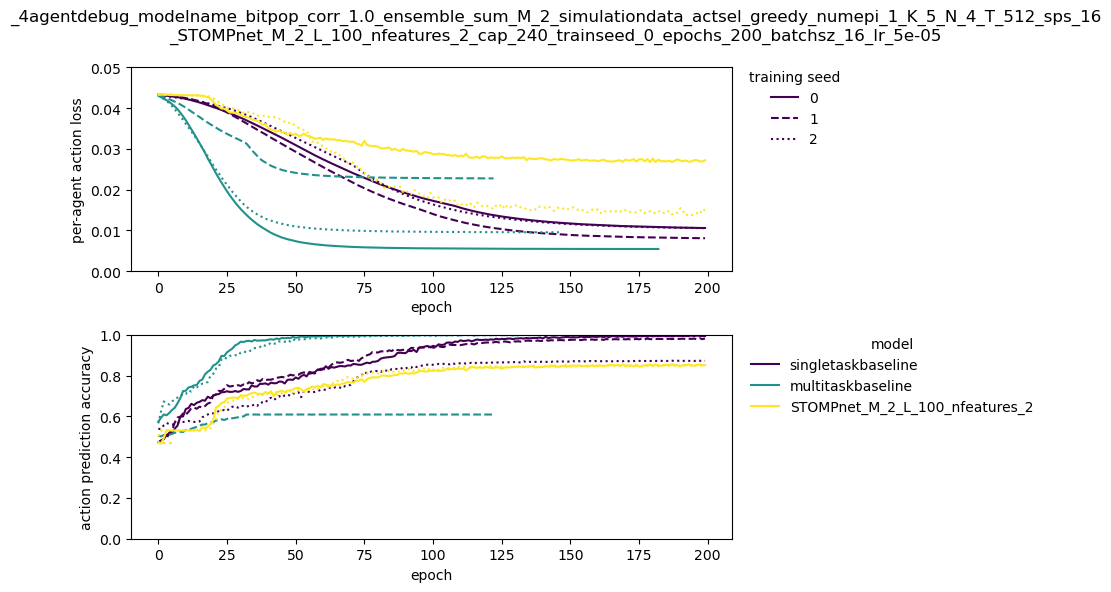

In [32]:
fig,ax=pl.subplots(2,1,figsize=(10,6))
mkr=['-','--',':']
colors=pl.cm.get_cmap('viridis')(np.linspace(0, 1, len(plist)))
for mit,model_name in enumerate(modellist):
    for git,g in enumerate(plist):
        if mit==0:
            ax[0].plot(data_dict[model_name][g]['loss'],mkr[git],color=colors[mit],label=g)
        else:
            ax[0].plot(data_dict[model_name][g]['loss'],mkr[git],color=colors[mit])
        ax[0].set_ylabel('per-agent action loss')
        ax[0].set_xlabel('epoch')
        ax[0].set_ylim(0,0.05)
        if git==0:
            ax[1].plot(data_dict[model_name][g]['accuracy'],mkr[git],color=colors[mit],label=model_name)
        else:
            ax[1].plot(data_dict[model_name][g]['accuracy'],mkr[git],color=colors[mit])
        ax[1].set_ylabel('action prediction accuracy')
        ax[1].set_xlabel('epoch')
        ax[1].set_ylim(0,1)
ax[0].legend(frameon=False,bbox_to_anchor=(1.2, 1.05),title='training seed')
ax[1].legend(frameon=False,bbox_to_anchor=(1.01, 1.05),title='model')
fig.suptitle(data_settings_str+'\n'+training_settings_str)
#     acc == (true == mdl(x).max(1).item() / true.size(0)
fig.tight_layout()
fig.savefig('results_fig.png', transparent=True, bbox_inches="tight", dpi=300)


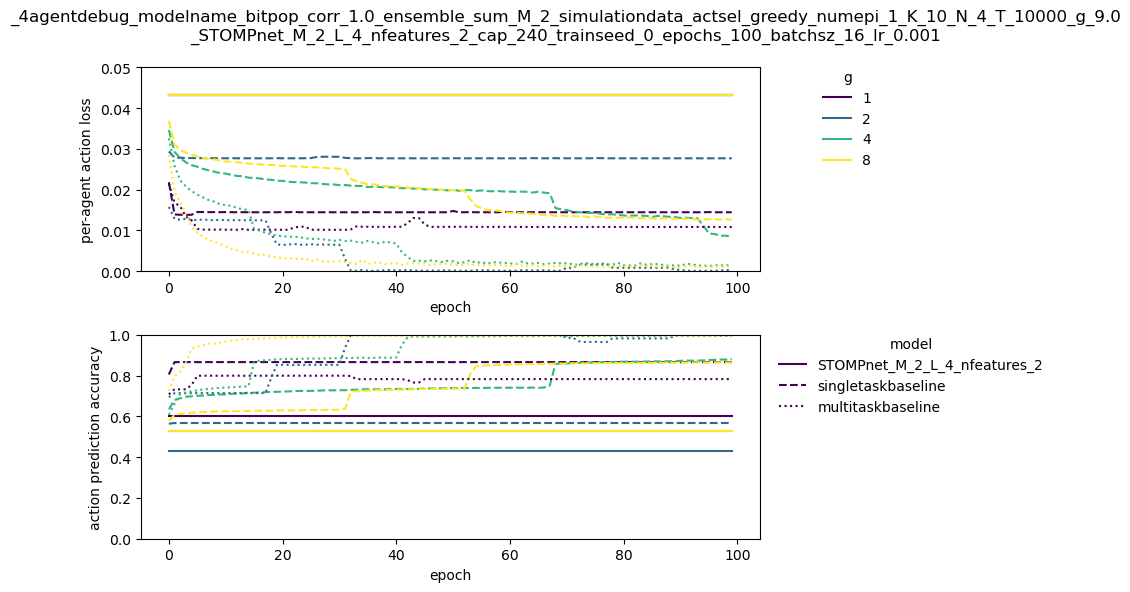

In [56]:
fig,ax=pl.subplots(2,1,figsize=(10,6))
mkr=['-','--',':']
colors=pl.cm.get_cmap('viridis')(np.linspace(0, 1, len(glist)))
for mit,model_name in enumerate(modellist):
    for git,g in enumerate(glist):
        if mit==0:
            ax[0].plot(data_dict[model_name][g]['loss'],mkr[mit],color=colors[git],label=g)
        else:
            ax[0].plot(data_dict[model_name][g]['loss'],mkr[mit],color=colors[git])
        ax[0].set_ylabel('per-agent action loss')
        ax[0].set_xlabel('epoch')
        ax[0].set_ylim(0,0.05)
        if git==0:
            ax[1].plot(data_dict[model_name][g]['accuracy'],mkr[mit],color=colors[git],label=model_name)
        else:
            ax[1].plot(data_dict[model_name][g]['accuracy'],mkr[mit],color=colors[git])
        ax[1].set_ylabel('action prediction accuracy')
        ax[1].set_xlabel('epoch')
        ax[1].set_ylim(0,1)
ax[0].legend(frameon=False,bbox_to_anchor=(1.2, 1.05),title='g')
ax[1].legend(frameon=False,bbox_to_anchor=(1.01, 1.05),title='model')
fig.suptitle(data_settings_str+'\n'+training_settings_str)
#     acc == (true == mdl(x).max(1).item() / true.size(0)
fig.tight_layout()
fig.savefig('results_fig.png', transparent=True, bbox_inches="tight", dpi=300)


In [16]:
net = get_untrained_STOMPnet(training_dict,data_settings)
# prelearning_probs=get_probs_on_vertices_from_model(net,data_settings)

Using cpu device
has 195594 parameters


In [1]:
net = get_untrained_net(training_dict,data_settings)
untrained_net_paras=net.state_dict()

NameError: name 'get_untrained_net' is not defined

In [88]:
from torch.nn import functional as F

In [95]:
parameter_name = 'ground_joint_policy.shared_ground_agent_policy_network.module_array.0.2.weight'
# parameter_name = 'assigner.abs_agent_assignment_embedding.weight'
# untrained_assignment_probs = F.softmax(untrained_net_paras[parameter_name],dim=1)
# trained_assignment_probs = F.softmax(trained_model_state_dict[parameter_name],dim=1)
untrained_para = untrained_net_paras[parameter_name]
trained_para = trained_model_state_dict[parameter_name]
print(untrained_para)
print(trained_para)
print(trained_para-untrained_para)

tensor([[-0.0215, -0.0015,  0.0267,  ..., -0.0222,  0.0430, -0.0476],
        [ 0.0565,  0.0276,  0.0012,  ...,  0.0209,  0.0361,  0.0549],
        [-0.0310,  0.0149, -0.0087,  ...,  0.0055,  0.0144,  0.0429],
        ...,
        [ 0.0408,  0.0101, -0.0102,  ..., -0.0377, -0.0371,  0.0137],
        [-0.0120, -0.0183,  0.0264,  ...,  0.0099, -0.0155, -0.0361],
        [-0.0415, -0.0433, -0.0298,  ...,  0.0143,  0.0379,  0.0112]])
tensor([[-0.0215, -0.0015,  0.0267,  ..., -0.0222,  0.0430, -0.0476],
        [ 0.0565,  0.0276,  0.0012,  ...,  0.0209,  0.0361,  0.0549],
        [-0.0310,  0.0149, -0.0087,  ...,  0.0055,  0.0144,  0.0429],
        ...,
        [ 0.0408,  0.0101, -0.0102,  ..., -0.0377, -0.0371,  0.0137],
        [-0.0120, -0.0183,  0.0264,  ...,  0.0099, -0.0155, -0.0361],
        [-0.0415, -0.0433, -0.0298,  ...,  0.0143,  0.0379,  0.0112]])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,

Does assigner learn to group 1st 2 and last two agents? Test: 

In [90]:
num_agents = 4
num_abs_agents = 2
group_size = int(num_agents/num_abs_agents)
probs=np.array([np.mean(np.array(trained_assignment_probs[:group_size,0])),
                np.mean(np.array(trained_assignment_probs[group_size:,0]))])
assigner_loss=np.min((np.linalg.norm(np.array([0,1])-probs),np.linalg.norm(np.array([1,0])-probs)))
assigner_loss

0.6644652518369977

In [91]:
prelearning_probs=get_probs_on_vertices_from_model(net,data_settings)
net.load_state_dict(trained_model_state_dict)
postlearning_probs=get_probs_on_vertices_from_model(net,data_settings)

In [93]:
postlearning_probs

array([[[0.5, 0.5],
        [0.5, 0.5],
        [0.5, 0.5],
        [0.5, 0.5]],

       [[0.5, 0.5],
        [0.5, 0.5],
        [0.5, 0.5],
        [0.5, 0.5]],

       [[0.5, 0.5],
        [0.5, 0.5],
        [0.5, 0.5],
        [0.5, 0.5]],

       ...,

       [[0.5, 0.5],
        [0.5, 0.5],
        [0.5, 0.5],
        [0.5, 0.5]],

       [[0.5, 0.5],
        [0.5, 0.5],
        [0.5, 0.5],
        [0.5, 0.5]],

       [[0.5, 0.5],
        [0.5, 0.5],
        [0.5, 0.5],
        [0.5, 0.5]]], dtype=float32)

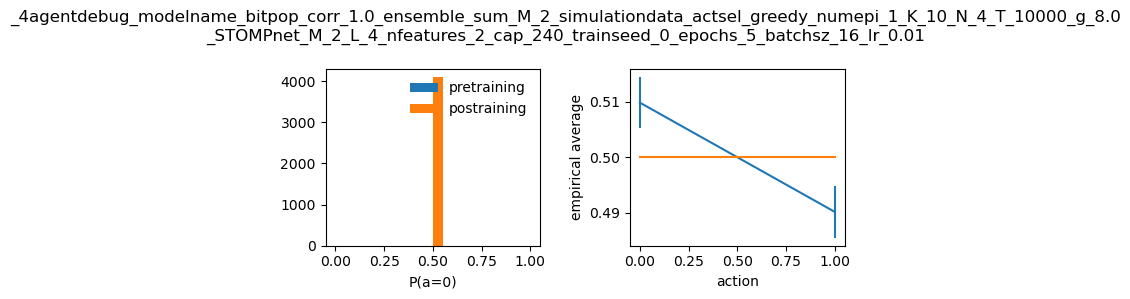

In [92]:
fig,ax = pl.subplots(1,2,figsize=(6,3))
ax[0].hist(prelearning_probs[:,:,0].flatten(),bins=np.linspace(0,1,21),label="pretraining")
ax[0].hist(postlearning_probs[:,:,0].flatten(),bins=np.linspace(0,1,21),label='postraining')
ax[0].set_xlabel('P(a=0)')
ax[0].legend(frameon=False)
ax[1].errorbar(x=range(len(prelearning_probs[0,0,:])),y=np.mean(prelearning_probs,axis=(0,1)),yerr=np.std(prelearning_probs,axis=(0,1)),label='pretraining')
ax[1].errorbar(x=range(len(postlearning_probs[0,0,:])),y=np.mean(postlearning_probs,axis=(0,1)),yerr=np.std(postlearning_probs,axis=(0,1)),label='posttraining')
ax[1].set_xlabel('action')
ax[1].set_ylabel('empirical average')
fig.suptitle(data_settings_str+'\n'+training_settings_str)
fig.tight_layout()

### Dataset analysis

In [71]:
def get_data(g):
    data_settings_str =\
                '_4agentdebug' +\
                '_modelname_bitpop' +\
                '_corr_0.2' +\
                '_ensemble_sum' +\
                '_M_2' +\
                '_simulationdata' +\
                '_actsel_greedy' +\
                '_numepi_1' +\
                '_K_10' +\
                '_N_4' +\
                '_T_10000' +\
                f'_g_'+g+'.0'
    seed_idx = 0
    out_dir = "output/"
    data_settings = np.load(out_dir + data_settings_str + ".npy", allow_pickle=True).item()
    epi_dims = [data_settings['num_episodes'],data_settings['episode_length']]
    data_root = out_dir + data_settings_str + f"_dataseed_{seed_idx}"
    training_data = np.load(data_root+".npy", allow_pickle=True).item()
    states=training_data["states"].reshape(tuple(epi_dims+[data_settings['sys_parameters']['K']]))
    actions=training_data["actions"].reshape(tuple(epi_dims+[data_settings['sys_parameters']['N']]))
    episode_times=training_data["times"].reshape(tuple(epi_dims+[1]))
    return states,actions, episode_times

In [45]:
out_dir = "output/"
data_settings = np.load(out_dir + data_settings_str + ".npy", allow_pickle=True).item()
    fig,ax=pl.subplots()
    ax.plot(states[epi_idx,:100,0])
    ax.plot(states[epi_idx,:100,1])
#     ax.set_ylim(-10,10)
# pl.gca().set_yscale('loout_dir = "output/"
data_settings = np.load(out_dir + data_settings_str + ".npy", allow_pickle=True).item()

IndentationError: unexpected indent (1848601439.py, line 3)

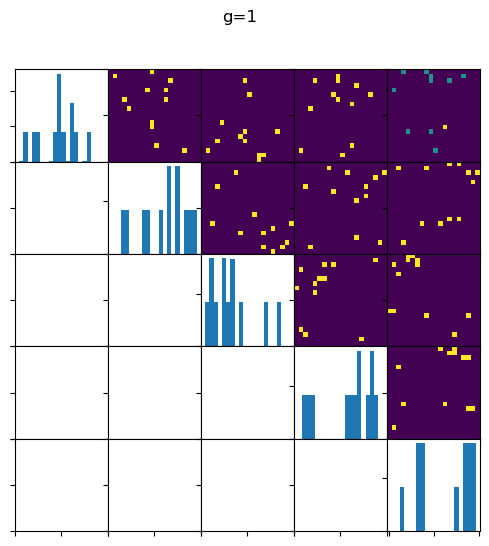

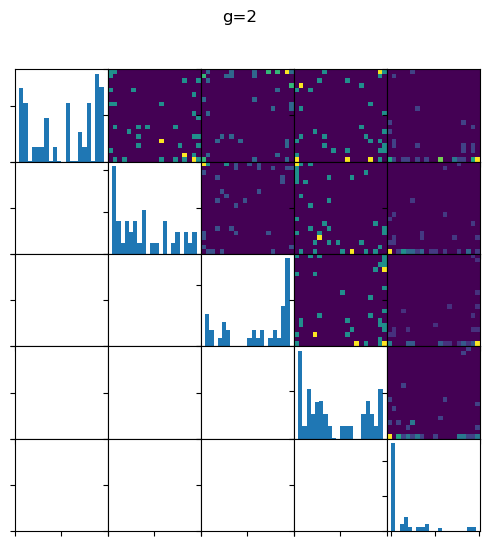

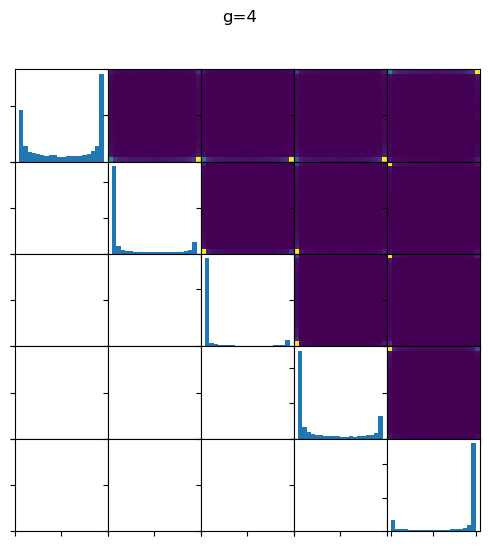

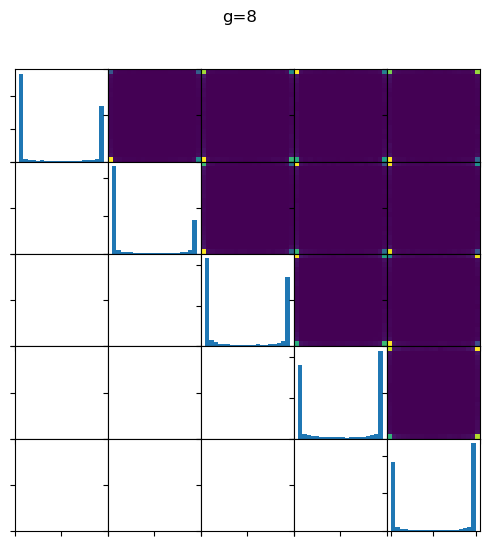

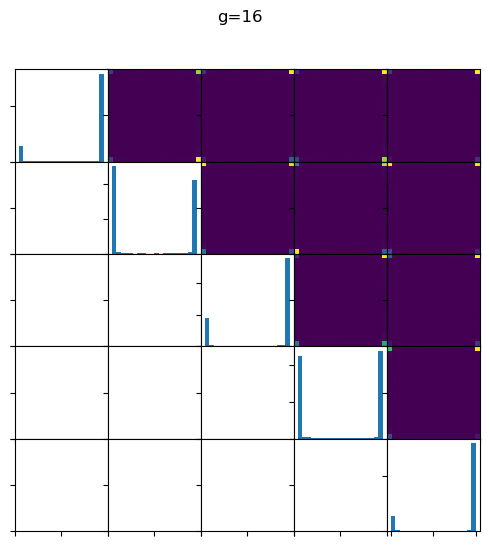

In [72]:
glist=[1,2,4,8,16]
for g in glist:
    states,actions,epi_times=get_data(str(g))
    Kmax=5#states.shape[1]
    fig,ax=pl.subplots(Kmax,Kmax,figsize=(6,6))
    for rit in range(Kmax):
        for cit in range(Kmax):
            if rit==cit:
                ax[rit,cit].hist(states[0,:,rit],bins=20)
            if rit<cit:
                heatmap, xedges, yedges = np.histogram2d(states[0,:,rit], states[0,:,cit], bins=20)
    #             extent = [0, 1, 0, 1]
                extent = [-1, 1, -1, 1]
                ax[rit,cit].imshow(heatmap.T, extent=extent, origin='lower')
            ax[rit,cit].set_xticklabels([])
            ax[rit,cit].set_yticklabels([])
    fig.suptitle('g='+str(g))
    fig.subplots_adjust(wspace=0, hspace=0)

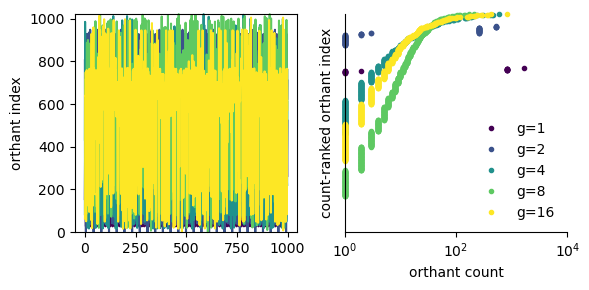

In [73]:
fig,ax=pl.subplots(1,2,figsize=(6,3))
colors=pl.cm.get_cmap('viridis')(np.linspace(0, 1, len(glist)))
store_states=[]
for git,g in enumerate(glist):
    states,actions,epi_times=get_data(str(g))
    store_states.append(states[0,:,:])
    orthant_index_seq=np.array([np.sum(np.power(2,np.arange(states.shape[2]))[state>0]) for state in states[0,:,:]])
    counts,bins=np.histogram(orthant_index_seq,bins=range(max(orthant_index_seq)+1));
    sorted_inds=np.argsort(counts)
    counts=counts[sorted_inds]

    ax[0].plot(orthant_index_seq[:1000],'-',clip_on=False,color=colors[git])
    ax[0].set_ylim(0,max(orthant_index_seq))
    ax[0].set_ylabel('orthant index')

    non_zero_counts=counts>0
    ax[1].plot(counts[non_zero_counts],bins[:-1][non_zero_counts],'.',color=colors[git],label="g="+str(g),clip_on=False)
    ax[1].set_yticks([])
    ax[1].set_xlabel('orthant count')
    ax[1].set_ylabel('count-ranked orthant index')
    ax[1].set_xscale('log')
    ax[1].set_ylim(0,max(orthant_index_seq)+1)
    ax[1].set_xlim(1,10000)
    ax[1].spines[['right', 'top']].set_visible(False)
    ax[1].legend(frameon=False)
    fig.tight_layout()
# ax[1].hist(orthant_index_seq,bins=np.arange(max(orthant_index_seq)),orientation="horizontal")

In [448]:
orthant_index_seq=np.array([np.sum(np.power(2,np.arange(states.shape[2]))[state>0]) for state in states.reshape((-1,data_settings['sys_parameters']['K']))])

In [449]:
values,counts=np.unique(orthant_index_seq,return_counts=True)

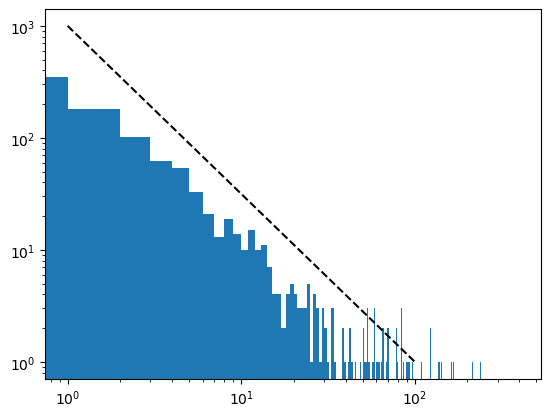

In [78]:
pl.hist(counts,bins=range(max(counts)+1));
pl.gca().set_yscale('log')
pl.gca().set_xscale('log')
pl.plot(np.arange(1,101),1000*np.arange(1,101)**(-3/2),'k--')

In [191]:
# plot binned states
df = pd.DataFrame(states, columns=range(states.shape[1]))
binned_df=(df>0.5)
outdf=binned_df.groupby(binned_df.columns.tolist(),as_index=False).size()#/len(df)
fig,ax=pl.subplots()
outdf['size'].apply(np.log10).hist(bins=50,ax=ax)
ax.set_xticklabels([r'$10^{'+x.get_text()+'}$' for x in ax.get_xticklabels()]);
ax.set_xlabel('orthant sample size')
ax.set_yscale('log')

ValueError: Must pass 2-d input. shape=(100, 100, 15)

## Untested

In [14]:
def get_probs_on_vertices_from_data(states,actions):
    vertex_states = torch.Tensor(list(itertools.product([0, 1], repeat=len(states[0]))))
    states=states>0.5
    actions_on_vertices=-np.ones((vertex_states.shape[0],actions.shape[1]))
    got_list=[]
    for i,binarized_state in enumerate(states[:20000]): 
        for j,vertex_state in enumerate(vertex_states):
            if np.all(binarized_state == vertex_state):
                actions_on_vertices[j]=actions[i]
                break
        if np.mod(i,100)==0:
            print(np.sum(actions_on_vertices==-1))
    return actions_on_vertices

In [15]:
 data_actions=get_probs_on_vertices_from_data(states,actions)

128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128


In [16]:
data_actions=data_actions[data_actions[:,0]!=-1]

/home/mptouzel/miniconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mptouzel/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


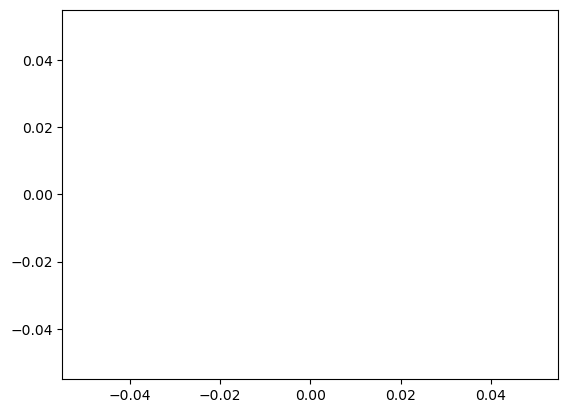

In [17]:
fig,ax=pl.subplots()
ax.plot(np.mean(data_actions,axis=0))

In [ ]:
from utils import get_corr_matrix
fig,ax=pl.subplots(1,2,figsize=(6,3))
ax[0].stem(np.mean(actions,axis=0))
ax[0].set_ylim(0,1)
ax[0].set_xticks(range(num_agents))
ax[0].set_ylabel("action frequency")
ax[0].set_xlabel("action index")

corr_matrix = get_corr_matrix(data["actions"][0])
p=ax[1].imshow(corr_matrix, extent=[
                  0.5, num_agents+0.5, 0.5, num_agents+0.5])
ax[1].set_xticks(range(1,data['sys_parameters']['N']+1))
ax[1].set_yticks(range(1,data['sys_parameters']['N']+1))
ax[1].set_xlim(0.5, num_agents+0.5)
ax[1].set_ylim(0.5, num_agents+0.5)
ax[1].set_ylabel('agent index')
ax[1].set_xlabel('agent index')
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(p, cax=cax, orientation='vertical')
ax[1].set_title("pairwise correlation")
fig.tight_layout()

In [ ]:
from utils import compare_plot
fig=compare_plot([outdir+data_filename])
fig.savefig(f'{data_filename[:-4]}_summary_fig.pdf', transparent=True, bbox_inches="tight", dpi=300)


In [ ]:
df = pd.DataFrame(states, columns=range(states.shape[1]))
axis_array=pd.plotting.scatter_matrix(df, alpha=0.2, figsize=(9,9));
for rit,row in enumerate(axis_array):
    for cit,axis in enumerate(row):
        if rit!=cit:
            heatmap, xedges, yedges = np.histogram2d(states[:,rit], states[:,cit], bins=50)
            extent = [0, 1, 0, 1]
#             axis.remove()
            axis.imshow(heatmap.T, extent=extent, origin='lower')

In [ ]:
fig,ax=pl.subplots(*axis_array.shape,figsize=(9,9))
for rit,row in enumerate(axis_array):
    for cit,axis in enumerate(row):
        if rit<cit:
            heatmap, xedges, yedges = np.histogram2d(states[:,rit], states[:,cit], bins=20)
            extent = [0, 1, 0, 1]
#             axis.remove()
            ax[rit,cit].imshow(heatmap.T, extent=extent, origin='lower')
        ax[rit,cit].set_xticklabels([])
        ax[rit,cit].set_yticklabels([])
fig.subplots_adjust(wspace=0, hspace=0)
# fig.tight_layout()

In [ ]:
fig,ax=pl.subplots()
outdf['size'].apply(np.log10).hist(bins=50,ax=ax)
ax.set_xticklabels([r'$10^{'+x.get_text()+'}$' for x in ax.get_xticklabels()]);
ax.set_xlabel('orthant visitation frequency')
ax.set_yscale('log')

View network?

In [7]:
from Environment import Environment
# Initialize environment
dummy_seed = 1
state_space_dim = 10
num_agents = 4
epsiode_length = 10000
fluctuation_strength_factor = 9.0
env = Environment(state_space_dim, num_agents, epsiode_length,
                  fluctuation_strength_factor=fluctuation_strength_factor, start_seed=dummy_seed)
env.state = env.sample_initial_state(seed=dummy_seed)
observed_state = env.state[:state_space_dim]

In [17]:
yhat=net(torch.unsqueeze(observed_state,dim=0))

In [21]:
from torchviz import make_dot

make_dot(yhat, params=dict(list(net.named_parameters()))).render("rnn_torchviz", format="png")

'rnn_torchviz.png'

In [119]:
from graphviz import Digraph, Source
import torch
from torch.autograd import Variable, Function

def iter_graph(root, callback):
    queue = [root]
    seen = set()
    while queue:
        fn = queue.pop()
        if fn in seen:
            continue
        seen.add(fn)
        for next_fn, _ in fn.next_functions:
            if next_fn is not None:
                queue.append(next_fn)
        callback(fn)

def register_hooks(var):
    fn_dict = {}
    def hook_cb(fn):
        def register_grad(grad_input, grad_output):
            fn_dict[fn] = grad_input
        fn.register_hook(register_grad)
    iter_graph(var.grad_fn, hook_cb)

    def is_bad_grad(grad_output):
        if grad_output is None:
            return True
        grad_output = grad_output.data
        return grad_output.ne(grad_output).any() or grad_output.gt(1e6).any()

    def make_dot():
        node_attr = dict(style='filled',
                        shape='box',
                        align='left',
                        fontsize='12',
                        ranksep='0.1',
                        height='0.2')
        dot = Digraph(node_attr=node_attr, graph_attr=dict(size="12,12"))

        def size_to_str(size):
            return '('+(', ').join(map(str, size))+')'

        def build_graph(fn):
            if hasattr(fn, 'variable'):  # if GradAccumulator
                u = fn.variable
                node_name = 'Variable\n ' + size_to_str(u.size())
                dot.node(str(id(u)), node_name, fillcolor='lightblue')
            else:
                assert fn in fn_dict, fn
                fillcolor = 'white'
                if any(is_bad_grad(gi) for gi in fn_dict[fn]):
                    fillcolor = 'red'
                dot.node(str(id(fn)), str(type(fn).__name__), fillcolor=fillcolor)
            for next_fn, _ in fn.next_functions:
                if next_fn is not None:
                    next_id = id(getattr(next_fn, 'variable', next_fn))
                    dot.edge(str(next_id), str(id(fn)))
        iter_graph(var.grad_fn, build_graph)

        return dot

    return make_dot

x = Variable(torch.randn(10, 10), requires_grad=True)
y = Variable(torch.randn(10, 10), requires_grad=True)

z = x / (y * 0)
z = z.sum() * 2
get_dot = register_hooks(z)
z.backward()
dot = get_dot()
dot.render('FileName', view=True)
# dot.save('tmp.dot')
# graph = Source('tmp.dot')
# graph


Format: "pdf" not recognized. Use one of: bmp canon cmap cmapx cmapx_np dot dot_json eps fig gd gd2 gif gv ico imap imap_np ismap jpe jpeg jpg json json0 mp pdf pic plain plain-ext png pov ps ps2 svg svgz tif tiff tk vdx vml vmlz vrml wbmp webp xdot xdot1.2 xdot1.4 xdot_json


CalledProcessError: Command '[PosixPath('dot'), '-Kdot', '-Tpdf', '-O', 'FileName']' returned non-zero exit status 1. [stderr: b'Warning: Could not load "/home/mptouzel/miniconda3/bin/../lib/graphviz/libgvplugin_pango.so.6" - It was found, so perhaps one of its dependents was not.  Try ldd.\nWarning: Could not load "/home/mptouzel/miniconda3/bin/../lib/graphviz/libgvplugin_pango.so.6" - It was found, so perhaps one of its dependents was not.  Try ldd.\nFormat: "pdf" not recognized. Use one of: bmp canon cmap cmapx cmapx_np dot dot_json eps fig gd gd2 gif gv ico imap imap_np ismap jpe jpeg jpg json json0 mp pdf pic plain plain-ext png pov ps ps2 svg svgz tif tiff tk vdx vml vmlz vrml wbmp webp xdot xdot1.2 xdot1.4 xdot_json\n']